In [1]:
import sys
import os

os.makedirs("images", exist_ok=True)
utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig, subplots
from dslabs_functions import (
    series_train_test_split,
    plot_forecasting_eval,
    plot_forecasting_series,
    plot_multiline_chart,
    HEIGHT,
    FORECAST_MEASURES,
    DELTA_IMPROVE,
)
from copy import deepcopy


In [2]:


def prepare_dataset_for_lstm(series, seq_length: int = 4):
    if len(series) <= seq_length:
        raise ValueError(
            f"Input series length ({len(series)}) is smaller than or equal to the sequence length ({seq_length})."
        )

    setX, setY = [], []
    for i in range(len(series) - seq_length):
        setX.append(series[i : i + seq_length])
        setY.append(series[i + 1 : i + seq_length + 1])

    setX = tensor(setX).float()  # Shape (samples, seq_length)
    setY = tensor(setY).float()  # Shape (samples, seq_length)

    if setX.dim() == 2:  # Add input_size dimension if needed
        setX = setX.unsqueeze(-1)  # Shape (samples, seq_length, 1)
        setY = setY.unsqueeze(-1)

    return setX, setY


class DS_LSTM(Module):
    def __init__(
        self,
        train,
        input_size: int = 1,
        hidden_size: int = 50,
        num_layers: int = 1,
        length: int = 4,
    ):
        super().__init__()
        self.lstm = LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(
            TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10
        )

    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM layer
        x = self.linear(x)  # Fully connected layer
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        if X.size(0) == 0:
            raise ValueError(
                "Input to predict is empty. Check the test dataset size and sequence length."
            )

        self.eval()
        with no_grad():
            x, _ = self.lstm(X)
            x = self.linear(x)
        return x.squeeze(-1).reshape(-1)


def lstm_study(
    train,
    test,
    nr_episodes: int = 1000,
    measure: str = "R2",
    file_tag: str = "Dataset",
    target: str = "Target",
):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure in ["R2", "MAPE"]
    best_model = None
    best_params = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance = float("-inf")

    _, axs = subplots(
        1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT)
    )

    for i, length in enumerate(sequence_size):
        # Skip configurations where the sequence length exceeds the dataset size
        if len(test) <= length:
            print(
                f"Skipping seq_length={length} due to insufficient test dataset size."
            )
            continue

        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden, length=length)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval_len = min(
                        len(test[length:].reshape(-1)), len(prd_tst)
                    )  # Align lengths
                    true_values = test[length:].reshape(-1)[:eval_len]
                    pred_values = prd_tst[:eval_len]
                    eval_metric = FORECAST_MEASURES[measure](true_values, pred_values)
                    print(
                        f"seq length={length} hidden_units={hidden} nr_episodes={n} {measure}={eval_metric:.4f}"
                    )

                    if (
                        eval_metric > best_performance
                        and abs(eval_metric - best_performance) > DELTA_IMPROVE
                    ):
                        best_performance = eval_metric
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval_metric)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    savefig(f"images/{file_tag}__LSTM_multi_study.png")
    print(
        f"LSTM best results with length={best_params['params'][0]}, hidden_units={best_params['params'][1]}, "
        f"nr_episodes={best_params['params'][2]} ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


File not found
seq length=2 hidden_units=25 nr_episodes=0 R2=-5.3250
seq length=2 hidden_units=25 nr_episodes=300 R2=-0.2976
seq length=2 hidden_units=25 nr_episodes=600 R2=-0.3092
seq length=2 hidden_units=25 nr_episodes=900 R2=-0.6418
seq length=2 hidden_units=25 nr_episodes=1200 R2=-0.7178
seq length=2 hidden_units=25 nr_episodes=1500 R2=-0.6903
seq length=2 hidden_units=25 nr_episodes=1800 R2=-0.7304
seq length=2 hidden_units=25 nr_episodes=2100 R2=-0.9604
seq length=2 hidden_units=25 nr_episodes=2400 R2=-0.8324
seq length=2 hidden_units=25 nr_episodes=2700 R2=-0.8863
seq length=2 hidden_units=25 nr_episodes=3000 R2=-0.7823
seq length=2 hidden_units=50 nr_episodes=0 R2=-5.3866
seq length=2 hidden_units=50 nr_episodes=300 R2=-0.3224
seq length=2 hidden_units=50 nr_episodes=600 R2=-0.7483
seq length=2 hidden_units=50 nr_episodes=900 R2=-0.7562
seq length=2 hidden_units=50 nr_episodes=1200 R2=-0.7980
seq length=2 hidden_units=50 nr_episodes=1500 R2=-0.7732
seq length=2 hidden_units=50

KeyboardInterrupt: 

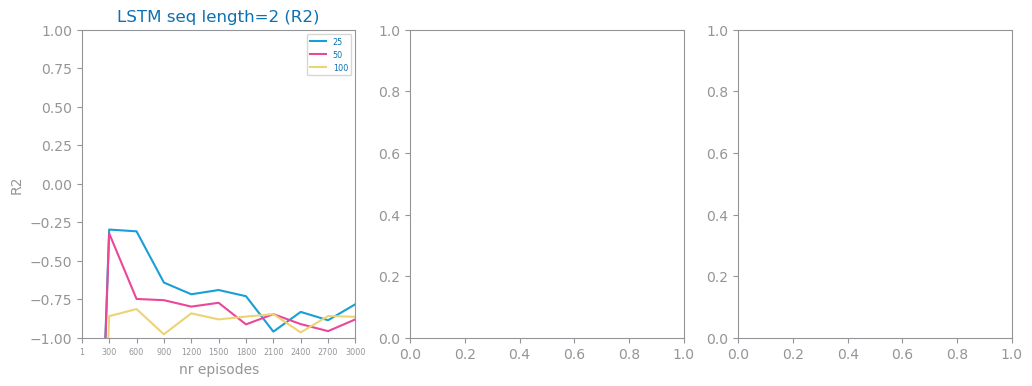

In [3]:
file_tag = "Arrest"
target = "Manhattan"
timecol = "Date"

data_path = os.path.abspath(os.path.join('..','..', 'data_copy/forecast_ny_arrests.csv'))
if not os.path.exists(data_path):
    print("File not found")
    data_path = os.path.abspath(os.path.join('..','..', 'data/f_s_forecast_ny_arrests.csv'))

def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col="Date",
        sep=";",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

data = load_data(data_path)
series = data[[target]].values.astype("float32")

train_size = int(len(series) * 0.90)
train, test = series[:train_size], series[train_size:]

best_model, best_params = lstm_study(
    train, test, nr_episodes=3000, measure="R2", file_tag=file_tag, target=target
)

# Evaluate and plot results
params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

print(f"Training input shape: {trnX.shape}")
print(f"Test input shape: {tstX.shape}")

# Ensure consistent lengths between ground truth and predictions
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

# Align lengths
min_len_train = min(len(train[best_length:]), len(prd_trn))
min_len_test = min(len(test[best_length:]), len(prd_tst))

aligned_train = train[best_length:][:min_len_train]
aligned_test = test[best_length:][:min_len_test]
aligned_prd_trn = prd_trn[:min_len_train]
aligned_prd_tst = prd_tst[:min_len_test]

# Plot evaluation
plot_forecasting_eval(
    aligned_train,
    aligned_test,
    aligned_prd_trn,
    aligned_prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"images/{file_tag}__multi_lstms_R2_eval.png")

# Create predicted series for visualization
pred_series = Series(
    aligned_prd_tst.numpy(),
    index=data.index[
        train_size + best_length : train_size + best_length + min_len_test
    ],
)

# Convert train and test data to pandas Series
aligned_train_series = Series(
    aligned_train.flatten(),
    index=data.index[best_length : best_length + len(aligned_train)],
    name="Train",
)

aligned_test_series = Series(
    aligned_test.flatten(),
    index=data.index[
        train_size + best_length : train_size + best_length + len(aligned_test)
    ],
    name="Test",
)

# Predicted series as pandas Series
pred_series = Series(
    aligned_prd_tst.numpy(),
    index=data.index[
        train_size + best_length : train_size + best_length + len(aligned_prd_tst)
    ],
    name="Prediction",
)
# Convert aligned arrays to pandas.Series with proper indices
aligned_train_series = Series(
    aligned_train.flatten(),
    index=data.index[best_length : best_length + len(aligned_train)],
    name="Train",
)

aligned_test_series = Series(
    aligned_test.flatten(),
    index=data.index[
        train_size + best_length : train_size + best_length + len(aligned_test)
    ],
    name="Test",
)

pred_series = Series(
    aligned_prd_tst.numpy(),
    index=data.index[
        train_size + best_length : train_size + best_length + len(aligned_prd_tst)
    ],
    name="Prediction",
)

# Plot forecasting series
plot_forecasting_series(
    aligned_train_series,
    aligned_test_series,
    pred_series,
    title=f"{file_tag} - LSTMs",
    xlabel=timecol,
    ylabel=target,
)

# Save the plot
savefig(f"images/{file_tag}_multi_lstms_R2_forecast.png")
